In [12]:
import numpy as np
import matplotlib.pyplot as plt

from squlearn import Executor
from squlearn.feature_map import ChebRx
from squlearn.expectation_operator import IsingHamiltonian
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import SLSQP

In [13]:
executor = Executor("statevector_simulator")

Define parameterized quantum circuit $Q(x,\theta)$

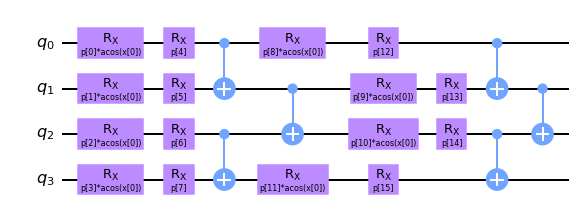

In [14]:
nqubits = 4

number_of_layers = 2
pqc = ChebRx(nqubits, 1, num_layers=number_of_layers)
pqc.draw()

Definition of the cost operator:
$\hat{H} = J \sum\limits_{i < j} Z_i Z_j + h\sum\limits_i Z_i + c$

In [15]:
ising_op = IsingHamiltonian(nqubits, I="S", Z="S", ZZ="S")
print(ising_op)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'IZZI', 'ZIIZ', 'ZIZI', 'ZZII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[1]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[1]), ParameterExpression(1.0*p[2]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[2]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[2]),
 ParameterExpression(1.0*p[2])])


Example function: $log(x)$

In [16]:
x_space = np.arange(0.1, 0.9, 0.1)
ref_values = np.log(x_space)

np.random.seed(13)
param_ini = np.random.rand(pqc.num_parameters)
param_op_ini = np.random.rand(ising_op.num_parameters)

reg = QNNRegressor(pqc, ising_op, executor, SquaredLoss(), SLSQP(), param_ini, param_op_ini)

Optimization of the regression

In [17]:
reg.fit(x_space, ref_values)

theta [0.77770241 0.23754122 0.82427853 0.9657492  0.97260111 0.45344925
 0.60904246 0.77552651 0.64161334 0.72201823 0.03503652 0.29844947
 0.05851249 0.85706094 0.37285403 0.67984795 0.25627995 0.34758122
 0.00941277]
pre-processing 0.003000497817993164
Number of circuits in the estimator: 8
Estimator run time 0.03703618049621582
post processing 0.0
Current value: 15.064846438837378
theta [0.77770241 0.23754122 0.82427853 0.9657492  0.97260111 0.45344925
 0.60904246 0.77552651 0.64161334 0.72201823 0.03503652 0.29844947
 0.05851249 0.85706094 0.37285403 0.67984795 0.25627995 0.34758122
 0.00941277]
pre-processing 0.028000831604003906
Number of circuits in the estimator: 256
Estimator run time 0.5630567073822021
post processing 0.003983974456787109
c
pre-processing 0.002000093460083008
Number of circuits in the estimator: 24
Estimator run time 0.07100033760070801
post processing 0.0
Grad length: 23.534559613237978
grad [ -0.05716598  -1.1969308   -2.5070993   -0.15684358  -0.26523052


In [18]:
print("Result Param:", reg._param)
print("Result ParamOp:", reg._param_op)

Result Param: [ 0.91858145 -1.1163345   0.38467092  1.39597102  1.10224011  2.41369111
  1.64968778 -0.81903595  0.4867727   0.38505193  1.10635672  0.72867129
 -1.74881862 -0.64411871  0.86344117 -0.91471452]
Result ParamOp: [-0.47157523  5.10755673  2.63075629]


pre-processing 0.0390012264251709
Number of circuits in the estimator: 140
Estimator run time 0.42999887466430664
post processing 0.001999378204345703


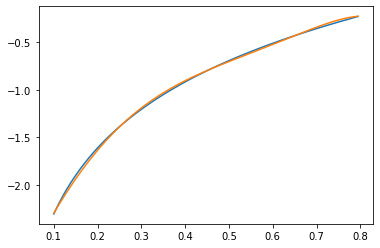

In [19]:
x = np.arange(np.min(x_space), np.max(x_space), 0.005)
y = reg.predict(x)
plt.plot(x, np.log(x))
plt.plot(x, y)

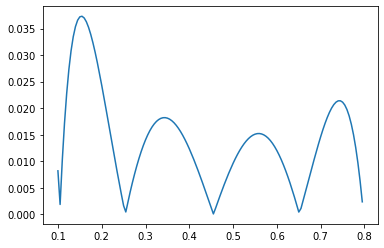

In [20]:
plt.plot(x, np.abs(y - np.log(x)))

C:\Users\DKR\Documents\Git Repositories\squlearn_fork\squlearn\src\squlearn\qnn\qnnr.py:133: UserWarning: The model is not fitted.
  warn("The model is not fitted.")


pre-processing 0.0410003662109375
Number of circuits in the estimator: 140
Estimator run time 1.9650404453277588
post processing 0.0019948482513427734


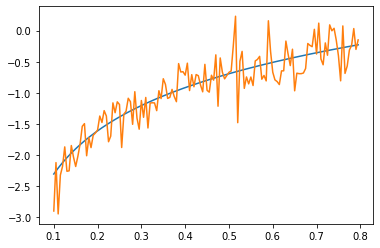

In [21]:
qasm = Executor("qasm_simulator")
qnn_qasm = QNNRegressor(pqc, ising_op, qasm, SquaredLoss, SLSQP(), reg._param, reg._param_op)
y = qnn_qasm.predict(x)
plt.plot(x, np.log(x))
plt.plot(x, y)

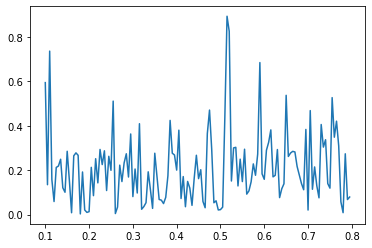

In [22]:
plt.plot(x, np.abs(y - np.log(x)))